In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ztest
from sklearn.linear_model import LinearRegression
!pip install pingouin
from pingouin import ancova

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 225kB 10.5MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.8-cp36-none-any.whl size=221687 sha256=77e9910815eaf4c0e3a8876c7ab33b941ac850792354d95ee6d860fe1e656ba7
  Stored in directory: /root/.cache/pip/wheels/d6/9e/53/f885f73f29cf7c8cac3d8f4b1532bbfef2f5eb543946ac9055
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4962 sha256=4afefa869a29744f14a8506da47dd74d097907aec00d616c95221c9f96e11cbb
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7050 sha256=8d82078d6efa658a6e01f1eda4f77ac342796ac8cdf99b51500c41293b8e26d4
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


## AB Tests

### 1. Оценка результатов AB теста

В данном задании вам требуется оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, вам даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

</u>Задача:</u>
1. Проверьте подходящую для данных гипотезу о равенстве средних в выборках
2. Каков treatment effect нашего воздействия? (ATE) 
3. Примените известные вам методы оценки ATE с учетом особенностей данных.
4. Проанализируйте, сравните результаты применения различных методов.
5. В явном виде выпишите выводы.

</i>Примечание: предположения о рандомизированном эксперименте нуждаются в проверке - независимость treatment от объектов не гарантирована. Все предположения выписывайте явно.</i> 

Для данной задачи используется dataset:  dataset_part1_students.csv

In [ ]:
dataset1 = pd.read_csv("dataset_part1_students.csv", sep='\t')

In [ ]:
dataset1.head()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736
2,5.378374,0.0,0.953214,0.137357,0.569413,0.975665,0.503367,0.667664,0.034191,0.456119,0.155851,0.476049
3,2.188189,1.0,0.169702,0.896258,0.373394,0.379693,0.858317,0.646061,0.583462,0.668350,0.177793,0.849248
4,2.862696,1.0,0.442373,0.831468,0.763921,0.919691,0.070573,0.156165,0.636894,0.555696,0.191929,0.425656


Выдвигаем гипотезу H0 о равенстве средних в выборках. Проверим её z-тестом.

In [ ]:
y0 = dataset1[dataset1['W'] == 0]['y']
y1 = dataset1[dataset1['W'] == 1]['y']

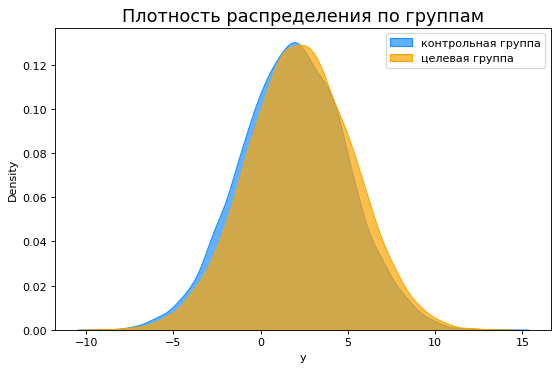

In [ ]:
plt.figure(figsize=(8,5), dpi=80)
sns.kdeplot(y0, shade=True, color="dodgerblue", label="контрольная группа", alpha=.7)
sns.kdeplot(y1, shade=True, color="orange", label="целевая группа", alpha=.7)
plt.title('Плотность распределения по группам', fontsize=16)
plt.legend()
plt.show()

In [ ]:
ztest(y0.values, y1.values)

(-9.332400850259313, 1.0349941796938945e-20)

Z-тест показал, что с большой долей вероятности нулевая гипотеза может быть отвергнута в пользу альтернативной, т. е. средние в выборках не равны.


Чтобы оценить ATE, нужно сначала понять, имеем ли мы дело с действительно рандомизированным экспериментом. Полагаем, что y в таблице - не таргет, а само оказанное воздействие, т. е. Y, т. к. по одному таргету определить ATE было бы невозможно. Но в таком случае получаем (исходя из z-теста), что Y и W зависимы, так как средние Y для разных значений W не равны.

Поэтому эксперимент нельзя считать рандомизированным. Это накладывает ограничения на поиск ATE. Его нельзя считать по наивной формуле, но при этом и первоначальных таргетов (показателей до начала эксперимента) у нас нет. Поэтому используем линейную регрессию для расчёта ATE:

In [ ]:
x_fit = dataset1.drop(['y'], axis=1)
linreg = LinearRegression()
linreg.fit(x_fit, dataset1['y'])
linreg.coef_[0]

0.5133854882565612

Для проверки рассчитаем разницу средних в выборках. Она должна отличаться от найденного выше ATE, т.к. W и Y не независимы.

In [ ]:
dataset1[dataset1['W'] == 1].mean()[0] - dataset1[dataset1['W'] == 0].mean()[0]

0.4001031055444413

Вывод: при неизвестных значениях y0 и y1 можно рассчитать ATE, используя Y. В случае независимости Y и W это можно сделать, вычислив разность средних Y в выборках, а в случае их зависимости можно использовать линейную регрессию для нахождения коэффициента перед W, который и будет являться ATE.

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Вы располагаете результатами до и после проведения теста (y_0 и y_1), а также вам дан treatment assignment (W). 

Необходимо: 
1. Проверить все требуемые гипотезы
2. Оценить ATE подходящим для этого случая методом (примените несколько методов)
3. Сравнить и проанализировать результаты оценок
4. Явно выписать выводы.

Как и прежде, все предположения должны быть указаны. Визуализация результатов приветствуется.

dataset_part2_students.csv

In [ ]:
dataset2 = pd.read_csv("dataset_part2_students.csv", sep='\t')

In [ ]:
dataset2.head()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209


Рассчитаем Y на основе известных y1 и y0.

In [ ]:
dataset2['Y'] = dataset2['y_1'] - dataset2['y_0']

In [ ]:
dataset2.head()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,Y
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310,3.102097
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161,-3.300914
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056,0.048874
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770,-6.036897
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209,0.797684


Выдвигаем гипотезу H0 о равенстве средних в выборках. Проверим её z-тестом.

In [ ]:
Y0 = dataset2[dataset2['W'] == 0]['Y']
Y1 = dataset2[dataset2['W'] == 1]['Y']

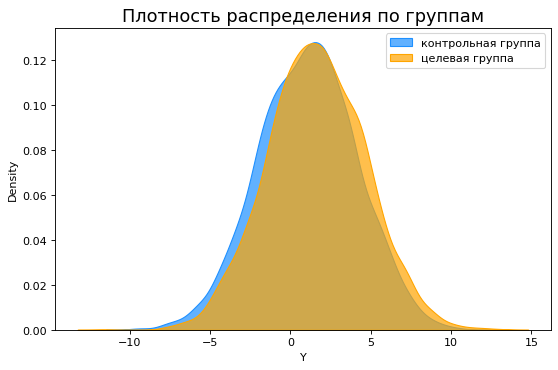

In [ ]:
plt.figure(figsize=(8,5), dpi=80)
sns.kdeplot(Y0, shade=True, color="dodgerblue", label="контрольная группа", alpha=.7)
sns.kdeplot(Y1, shade=True, color="orange", label="целевая группа", alpha=.7)
plt.title('Плотность распределения по группам', fontsize=16)
plt.legend()
plt.show()

In [ ]:
ztest(Y0.values, Y1.values)

(-9.118025905018952, 7.650513264824386e-20)

Z-тест показал, что с большой долей вероятности нулевая гипотеза может быть отвергнута в пользу альтернативной, т. е. средние в выборках не равны.


W и Y не являются независимыми, поэтому используем различные методы оценки ATE, допускающие их зависимость. Теперь у нас больше возможностей, чем в первом пункте, т. к. помимо рассчитанного Y есть также y0 и y1.

In [ ]:
# оценка ATE при помощи линейной регрессии

x_fit2 = dataset2.drop(['y_1', 'y_0', 'Y'], axis=1)
linreg = LinearRegression()
linreg.fit(x_fit2, dataset2['Y'])
linreg.coef_[0]

0.542507153183225

In [ ]:
# оценка ATE при помощи DiD

import statsmodels.formula.api as smf

did = smf.ols(formula='Y ~ W', data=dataset2).fit()
did.params[1]

0.5549047702971194

In [ ]:
# оценка ATE при помощи CUPED

theta = (np.cov(dataset2['y_1'], dataset2['y_0']) / np.var(dataset2['y_0']))[0][1]
t_cuped = dataset2['y_1'] - (dataset2['y_0'] - dataset2['y_0'].mean()) * theta

linreg.fit(x_fit2, t_cuped)
linreg.coef_[0]

0.5480592658356855

In [ ]:
# оценка воздействия при помощи ANCOVA

ancova(data=dataset2, dv='y_1', covar='y_0', between='W')

,Source,SS,DF,F,p-unc,np2
0,W,470.516935,1,110.511304,1.030891e-25,0.010934
1,y_0,35.934216,1,8.439945,3.678721e-03,0.000844
2,Residual,42563.589659,9997,NaN,NaN,NaN


Вывод: полученные разными методами ATE при известных начальных и конечных y оказались достаточно близки друг к другу, что подтверждает правильность выбранного способа оценки (любого из).

### 3. Построение uplift модели по результатам AB теста.

Вам даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.

Задача:
1. Оцените ATE по данным.
2. Оцените CATE для каждого наблюдения.
3. Проставьте рекомендации к воздействию на каждый объект.
4. Какая ожидаемая конверсия при оптимальном воздействии?
5. Все выводы, предпосылки и методы представляйте в явном виде в ноутбуке.

Визуализация результатов также будет приветствоваться.

dataset_part3_students.csv

In [ ]:
dataset3 = pd.read_csv("dataset_part3_students.csv", sep='\t')

In [ ]:
dataset3.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0


Оценим ATE при помощи линейной регрессии, первоначально приведя данные в столбце treatment к float:

In [ ]:
t_dict = {'control': 0.0, 'treatment': 1.0}
dataset3['treatment'] = dataset3['treatment'].transform(lambda x: t_dict.get(x))
x_fit3 = dataset3.drop(['conversion'], axis=1)
linreg = LinearRegression()
linreg.fit(x_fit3, dataset3['conversion'])
linreg.coef_[0]

0.06024252397448968

Оценим CATE при помощи S-learner:

In [ ]:
x0 = x_fit3.copy()
x0['treatment'] = x0['treatment'].transform(lambda x: 0)
x1 = x_fit3.copy()
x1['treatment'] = x1['treatment'].transform(lambda x: 1)

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=10)
forest.fit(x_fit3, dataset3['conversion'])
CATE_s_l = forest.predict_proba(x1)[:, 0] - forest.predict_proba(x0)[:, 0]
CATE_s_l

array([ 0.00026366, -0.00138163, -0.00427526, ...,  0.00894706,
        0.00204484,  0.00344069])

Оценим CATE при помощи T-learner:

In [ ]:
dataset3_0 = dataset3[dataset3['treatment'] == 0]
dataset3_1 = dataset3[dataset3['treatment'] == 1]
x_test = x_fit3.drop(['treatment'], axis=1)
x_fit3_0 = dataset3_0.drop(['treatment', 'conversion'], axis=1)
x_fit3_1 = dataset3_1.drop(['treatment', 'conversion'], axis=1)
forest0 = RandomForestClassifier(max_depth=10)
forest1 = RandomForestClassifier(max_depth=10)
forest0.fit(x_fit3_0, dataset3_0['conversion'])
forest1.fit(x_fit3_1, dataset3_1['conversion'])
CATE_t_l = forest1.predict_proba(x_test)[:, 0] - forest0.predict_proba(x_test)[:, 0]
CATE_t_l

array([-0.00774859,  0.00324101, -0.01877437, ...,  0.02687849,
        0.00538136,  0.00769077])

На основе полученного CATE проставим рекомендации (1 - если рекомендуем, 0 - если нет):

In [ ]:
dataset3['recommendation'] = CATE_t_l * dataset3['conversion'].transform(lambda x: 1 if x == 0 else 0)
dataset3['recommendation'] = dataset3['recommendation'].transform(lambda x: 0 if x <= 0 else 1)

In [ ]:
dataset3.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,recommendation
0,0.0,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0,0
1,0.0,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0,1
2,0.0,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0,0
3,1.0,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1,0
4,0.0,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0,0


Рассчитаем конверсию (в процентах) при подобранных рекомендациях по воздействию:

In [ ]:
dataset3['recommendation'].value_counts()[1] / dataset3['conversion'].value_counts()[0] * 100

30.266862637459933

Вывод: рассчитывая CATE, можно анализировать текущую конверсию и предлагать меры по её улучшению. CATE можно было рассчитывать не вручную, а при помощи существующих библиотек (например, causalml - но я пытался использовать их s-learner, он выдавал ошибку на предикте, поэтому реализовал s-learner вручную).